# Tutorial sobre la Técnica de Kmeans

## 1. Fundamentos de la técnica

El método de agrupamiento k-means es un algoritmo de aprendizaje **no supervisado** utilizado para la agrupación de clústeres de datos.

A diferencia de otras técnicas de aprendizaje supervisado, como lo son kNN y el perceptrón, el objetivo de k-means no es predecir una etiqueta correcta, sino encontrar un patrón oculto en los datos.

El proceso que sigue este algoritmo es el siguiente:
1. Se define un número 'k' de clústeres (o grupos) que se quieren encontrar.
2. Se inicializan 'k' centroides (los centros de los clústeres) de forma aleatoria.
3. Se repiten dos pasos hasta que converge el algoritmo:
   * Se asigna cada punto al centroide más cercano
   * Se recalcula la posición de cada centroide moviéndolo al centro de todos los puntos asignados a ese clúster.

## 2. Modelo matemático

El objetivo matemático de K-Means es **minimizar la Inercia**, también conocida como "Suma de cuadrados dentro del clúster" (WCSS).

La **Inercia** es la suma total de las distancias al cuadrado desde cada punto de dato ($x_i$) hasta el centroide de su clúster asignado ($\mu_k$).

Para un conjunto de datos con $K$ clústeres, la fórmula de la Inercia ($J$) es:

$$J = \sum_{k=1}^{K} \sum_{x_i \in C_k} ||x_i - \mu_k||^2$$

Donde:
* $K$ es el número de clústeres.
* $C_k$ es el conjunto de todos los puntos de datos asignados al clúster $k$.
* $\mu_k$ es el centroide (la media) del clúster $k$.
* $||x_i - \mu_k||^2$ es la distancia Euclidiana al cuadrado.

El algoritmo K-Means no garantiza encontrar el mínimo *global* de esta función, ya que puede caer en un mínimo local, por lo que Scikit-learn lo ejecuta múltiples veces por defecto (`n_init=10`) con diferentes centroides iniciales para encontrar el mejor resultado.

## 3. Descripción de las librerías, clases y funciones

Para implementar el modelo se usará Scikit-learn; para el análisis, Pandas; y para graficar, Matplotlib.

Antes de detallar cada herramienta a utilizar, primero importamos las librerías y funciones:

In [8]:
# Configuración de esta variable de entorno para suprimir una advertencia de fuga de memoria en Windows
# aunque, para este notebook, se puede ignorar pues tiene prácticamente un nulo impacto
import os
os.environ["OMP_NUM_THREADS"] = "2"

# Importaciones generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funciones de Scikit-learn para la generación de datos y preprocesamiento
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Modelo KMeans
from sklearn.cluster import KMeans

# Configuración para que los gráficos se muestren en el notebook
%matplotlib inline

Las herramientas empleadas hasta ahora son las siguientes:

* `make_blobs`: Es una función de `sklearn` ideal para clustering la cual permite crear "manchas" (blobs) de datos sintéticos.
* `pandas`: Se usará para crear un `DataFrame` y calcular fácilmente el análisis estadístico con `.describe()`.
* `StandardScaler`: Al igual que kNN, K-Means se basa en la distancia Euclidiana, por lo que escalar las características (media=0, varianza=1) es un paso de preprocesamiento esencial.
* `KMeans`: Esta es la clase de `sklearn` que implementa el algoritmo. Su hiperparámetro clave es `n_clusters` (el valor de 'k'). El modelo entrenado expone la Inercia final en su atributo `.inertia_`.

## 4. Pipeline

### Preprocesamiento

Para esta etapa se generarán los datos, para este caso, de manera sintética, se realizará el análisis estadístico y la gráfica de los datos antes de aplicar el modelo.

Cabe aclarar que como este algoritmo es no supervisado, no es necesario dividir los datos en conjuntos de entrenemiento y pruebas, sino que se ajustará el modelo (fit) a todo el conjunto de datos `X`.

Análisis Estadístico Descriptivo de las Características
        Feature 1   Feature 2
count  300.000000  300.000000
mean    -1.436969   -1.646411
std      5.334264    5.218787
min     -8.928775  -11.055225
25%     -5.580402   -8.053573
50%     -3.912592    0.563191
75%      5.021518    2.578222
max      8.409263    6.341387




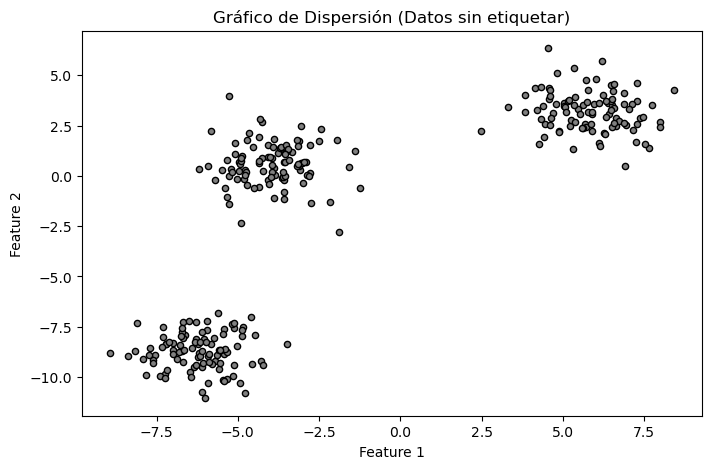

In [3]:
# Generaremos 300 muestras, 2 características y 3 centros (clústeres), además de la desviación estándar por default y un número conveniente para
# generar los mismos datos con random_state
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=1.0, random_state=17)

# Análisis estadístico usando Pandas
# Convertir X a un DataFrame
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
print("Análisis Estadístico Descriptivo de las Características")
print(df.describe())
print("\n")

# Gráfico de dispersión sin etiquetas
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c='gray', edgecolors='k', s=20)
plt.title("Gráfico de Dispersión (Datos sin etiquetar)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Escalado de Características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Prediction

Antes de comenzar a definir una función que aplique el modelo, primero se debe definir el modelo, junto con otros valores.

In [4]:
# Definir el valor de k
k_fijo = 3

# Crear la instancia del modelo
# 'init="k-means++"' es una inicialización inteligente
# 'n_init=10' ejecuta el algoritmo 10 veces y se queda con el mejor resultado
kmeans_model = KMeans(n_clusters=k_fijo, init='k-means++', n_init=10, random_state=17)

# "Entrenar" el modelo para encontrar los centroides
kmeans_model.fit(X_scaled)

print(f"Modelo K-Means (k={k_fijo}) entrenado.")

# También se puede imprimir la Inercia final para este modelo específico
print(f"Inercia (WCSS) para k=3: {kmeans_model.inertia_:.2f}")

Modelo K-Means (k=3) entrenado.
Inercia (WCSS) para k=3: 22.31


Una vez hecho esto, se puede continuar con la creación de la función para aplicar el modelo de clustering, el cual busca predecir el ID del clúster al que pertenece un nuevo patrón, como se muestra a continuación:

In [17]:
def predecir_cluster(modelo, scaler, patron_nuevo):
    
    # Nos aseguramos de que el patrón sea un array de NumPy
    patron_array = np.array(patron_nuevo)
    
    # Convertir el array 1D a 2D (1 muestra, 2 características)
    patron_2d = patron_array.reshape(1, -1)
    
    # Escalar el patrón usando el mismo scaler de los datos de entrenamiento
    patron_scaled = scaler.transform(patron_2d)
    
    # Predecir el clúster
    prediccion = modelo.predict(patron_scaled)
    
    # Obtener el ID del clúster
    cluster_id = prediccion[0]
    
    print(f"Patrón de entrada: {patron_nuevo}")
    print(f"ID de Clúster Predicho: {cluster_id}")
    print("-" * 30)

# Pruebas de la función

# Obtener los centroides en coordenadas escaladas del modelo
centroids_scaled = kmeans_model.cluster_centers_

# Revertir el escalado para ver sus coordenadas originales
centroids_original = scaler.inverse_transform(centroids_scaled)

print(f"Centroides originales encontrados:")
print(centroids_original)
print("\n--- Probando la función con los centroides encontrados ---")

# Probamos la función de predicción usando los propios centroides.

# Prueba 1: Probar el primer centroide
patron_1 = centroids_original[0]
predecir_cluster(kmeans_model, scaler, patron_1)

# Prueba 2: Probar el segundo centroide
patron_2 = centroids_original[1]
predecir_cluster(kmeans_model, scaler, patron_2)

# Prueba 3: Probar el tercer centroide
patron_3 = centroids_original[2]
predecir_cluster(kmeans_model, scaler, patron_3)

Centroides originales encontrados:
[[-6.20004403 -8.71900955]
 [ 5.83117149  3.21192503]
 [-3.94203592  0.56785117]]

--- Probando la función con los centroides encontrados ---
Patrón de entrada: [-6.20004403 -8.71900955]
ID de Clúster Predicho: 0
------------------------------
Patrón de entrada: [5.83117149 3.21192503]
ID de Clúster Predicho: 1
------------------------------
Patrón de entrada: [-3.94203592  0.56785117]
ID de Clúster Predicho: 2
------------------------------


### Model Evaluation

Como k-means es un algoritmo **no supervisado**, no se pueden usar métricas como **Accuracy** o **Matriz de Confusión**.

En su lugar, se usará la métrica **Inercia (WCSS)**, la cual mide qué tan "compactos" son los clústeres (la suma de las distancias al cuadrado de cada punto a su centroide), como ya se mencionaba al comienzo de este notebook.

Sin embargo, existe una limitación de la Inercia, pues siempre disminuye a medida que aumentamos 'k'. Con k=1, la inercia es máxima; con k=N, la inercia es 0. Por lo tanto, la solución es implementar el **Método del codo** para encontrar el valor óptimo de 'k', probando varios valores de y graficando su inercia, es decir, se busca el punto donde la inercia deja de disminuir: "el codo".

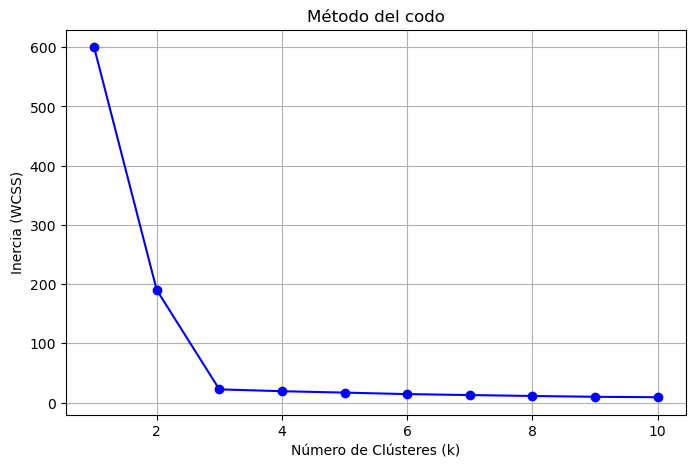

In [5]:
# Crear una lista para guardar las inercias para cada k
inertia_values = []

# Definir un rango de 'k' para probar
k_range = range(1, 11)

# Calcular la inercia para cada k
for k in k_range:
    # Crear y entrenar un modelo para este 'k'
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=17)
    model.fit(X_scaled)
    # Guardar su inercia
    inertia_values.append(model.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, 'bo-') # 'bo-' = blue dots with solid line
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del codo')
plt.grid(True)
plt.show()

Con este método se puede determinar que la inercia disminuye rápidamente cuando 'k' pasa de 1 a 2, y cuando pasa de 2 a 3, mientras que después de este último valor, la inercia prácticamente no disminuye y se aprecia la forma del codo.

Por lo tanto, se puede concluir que el uso de k=3 en el modelo fue la ideal.

Para finalizar, usamos el modelo que entrenamos con k=3 (`kmeans_model`) para visualizar los clústeres que encontró.

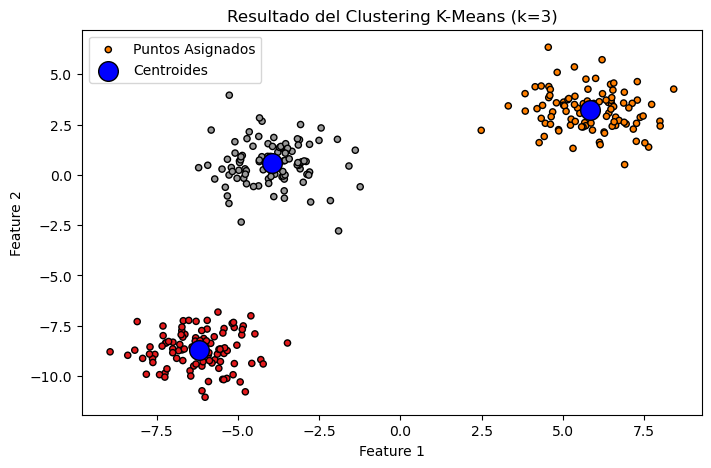

In [6]:
# Obtener las etiquetas del modelo con k=3
labels = kmeans_model.labels_

# Obtener los centroides en coordenadas escaladas
centroids_scaled = kmeans_model.cluster_centers_

# Revertir el escalado de los centroides para graficarlos sobre los datos originales
centroids_original = scaler.inverse_transform(centroids_scaled)

# Graficar
plt.figure(figsize=(8, 5))
# Graficar los puntos de datos, coloreados por sus etiquetas (labels)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set1', edgecolors='black', s=20, label='Puntos Asignados')
# Graficar los centroides
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='blue', s=200, marker='o', edgecolors='black', label='Centroides')

plt.title(f"Resultado del Clustering K-Means (k={k_fijo})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## Referencias

* Kavlakoglu, E., & Winland, V. (2025, 13 febrero). K-Means Clustering. Think. https://www.ibm.com/mx-es/think/topics/k-means-clustering
* KMEANS. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* A demo of K-Means clustering on the handwritten digits data. (s. f.). Scikit-learn. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html